In [1]:
import os
import cv2
import joblib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sentence_transformers import SentenceTransformer
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import warnings
warnings.filterwarnings("ignore")
from pymongo import MongoClient
client = MongoClient('mongodb://localhost:27017')

C:\Users\VuongPham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Mô hình cơ bản

Số lượng đặc trưng được sử dụng để huấn luyện: 21
Báo cáo phân loại đa mức:

 Like_Level
              precision    recall  f1-score   support

        High       0.77      0.74      0.76       267
      Medium       0.48      0.66      0.55       272
         Low       0.71      0.70      0.71       803
    Very Low       0.70      0.80      0.75      1885
        None       0.89      0.75      0.81      2193

    accuracy                           0.75      5420
   macro avg       0.71      0.73      0.72      5420
weighted avg       0.77      0.75      0.76      5420


 Reply_Level
              precision    recall  f1-score   support

        High       0.76      0.81      0.78       264
      Medium       0.55      0.64      0.59       264
         Low       0.68      0.75      0.71       753
    Very Low       0.38      0.70      0.50       955
        None       0.92      0.65      0.77      3184

    accuracy                           0.68      5420
   macro avg       0.66     

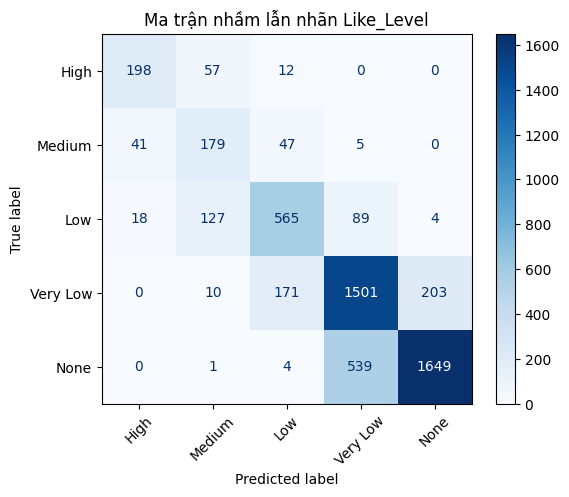

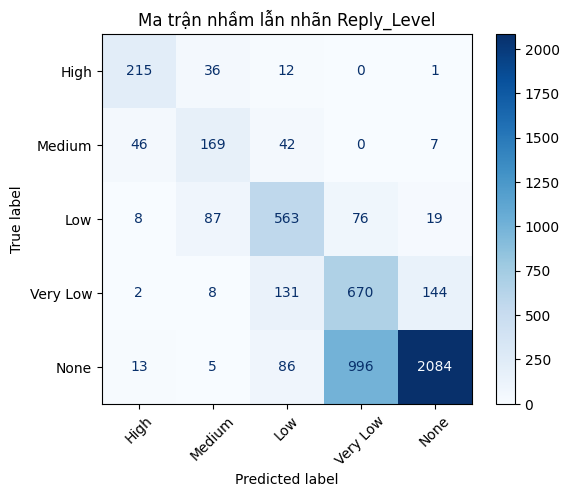

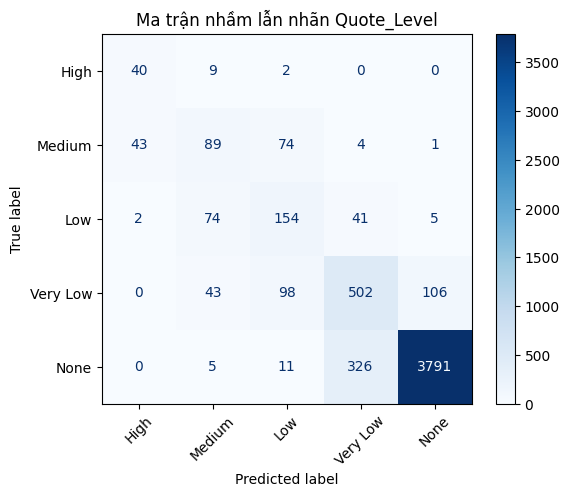

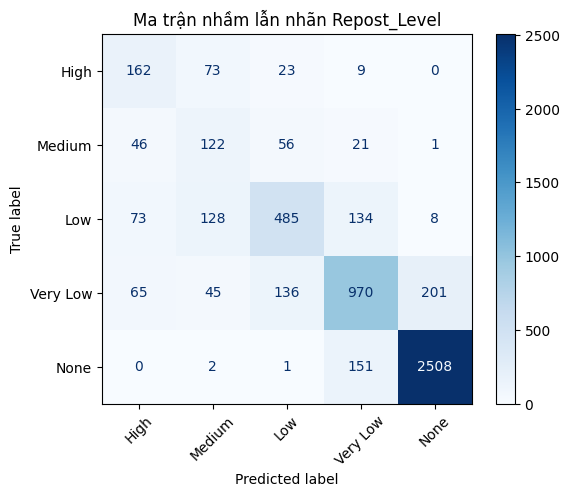

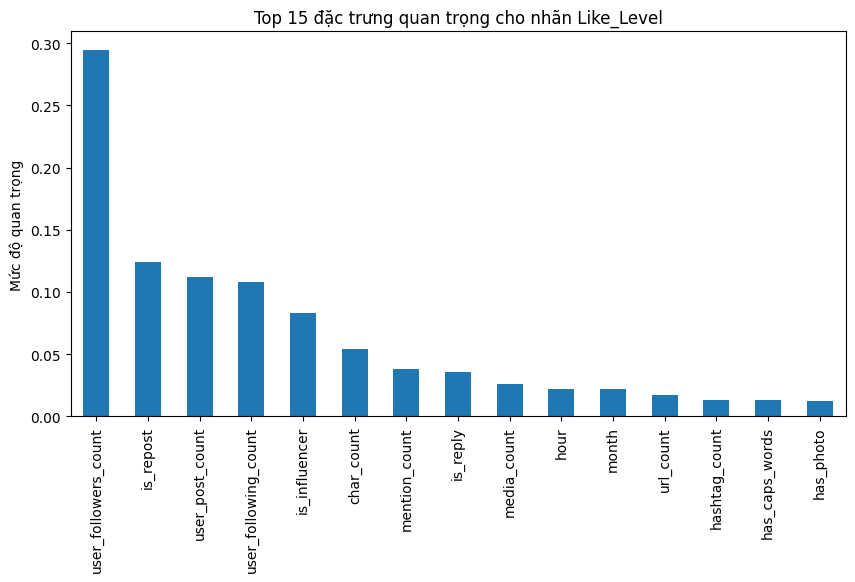

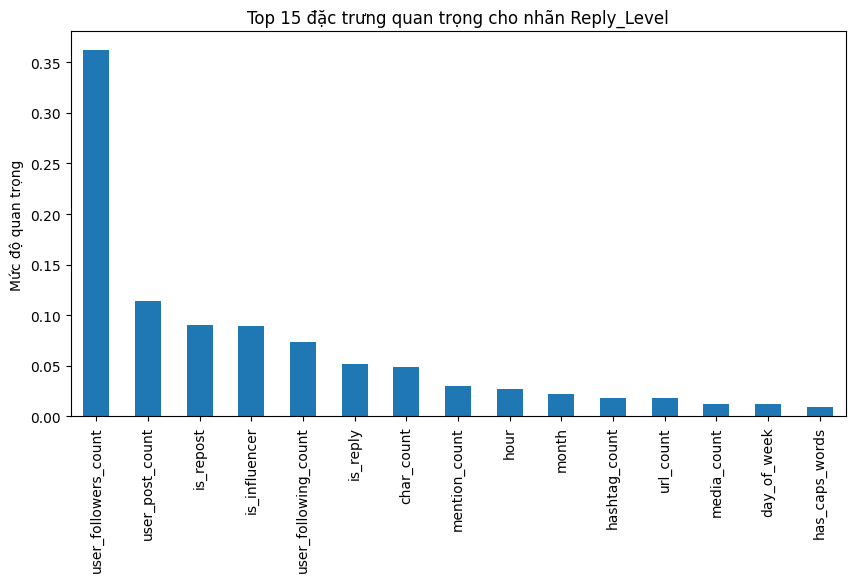

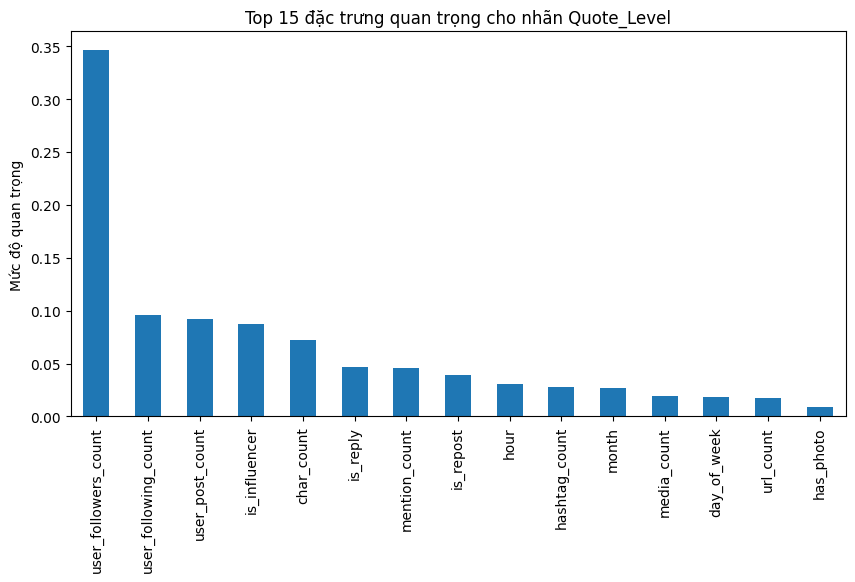

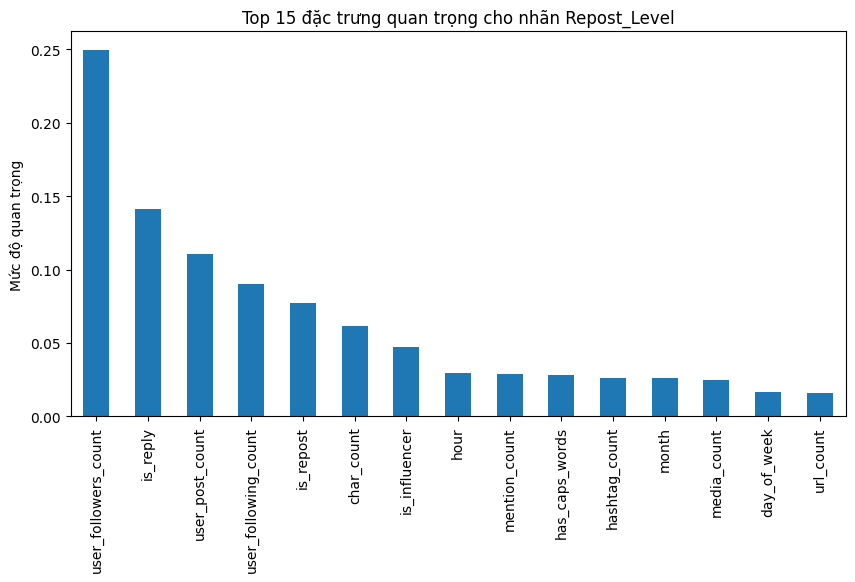

['model/model_base_multiclass.joblib']

In [6]:
# Kết nối dữ liệu
collection = client['db']['posts_base']
df = pd.DataFrame(list(collection.find()))

# Xác định cột đầu ra
target_cols = ['Like_Level', 'Reply_Level', 'Quote_Level', 'Repost_Level']
feature_cols = [col for col in df.columns if col not in target_cols + ['_id']]

# Chuyển đổi nhãn sang số
label_encoders = {}
for col in target_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

X = df[feature_cols]
y = df[target_cols]

print(f"Số lượng đặc trưng được sử dụng để huấn luyện: {X.shape[1]}")

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=20
)

# Huấn luyện mô hình đa nhãn (multi-class cho từng nhãn)
rf = RandomForestClassifier(
    n_estimators=300,
    max_features=0.4,
    min_samples_leaf=12,
    max_depth=12,
    class_weight='balanced',
    n_jobs=-1,
    random_state=20
)
multi_rf = MultiOutputClassifier(rf)
multi_rf.fit(X_train, y_train)

# Đánh giá
order_labels = ['High', 'Medium', 'Low', 'Very Low', 'None']
label_to_ordered_int = {label: i for i, label in enumerate(order_labels)}

def reorder_labels(arr, le, label_to_ordered_int):
    original_labels = le.inverse_transform(arr)
    reordered = [label_to_ordered_int[label] for label in original_labels]
    return np.array(reordered)

print('Báo cáo phân loại đa mức:')
for i, label in enumerate(target_cols):
    le = label_encoders[label]
    y_test_reordered = reorder_labels(y_test.iloc[:, i].values, le, label_to_ordered_int)
    y_pred_reordered = reorder_labels(multi_rf.predict(X_test)[:, i], le, label_to_ordered_int)

    print(f"\n {label}")
    print(classification_report(
        y_test_reordered,
        y_pred_reordered,
        target_names=order_labels,
        zero_division=0
    ))

# Ma trận nhầm lẫn
for i, label in enumerate(target_cols):
    le = label_encoders[label]
    y_test_reordered = reorder_labels(y_test.iloc[:, i].values, le, label_to_ordered_int)
    y_pred_reordered = reorder_labels(multi_rf.predict(X_test)[:, i], le, label_to_ordered_int)

    cm = confusion_matrix(y_test_reordered, y_pred_reordered)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=order_labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f'Ma trận nhầm lẫn nhãn {label}')
    plt.show()

# Độ quan trọng đặc trưng
for i, label in enumerate(target_cols):
    importances = multi_rf.estimators_[i].feature_importances_
    feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

    plt.figure(figsize=(10,5))
    feat_imp.head(15).plot(kind='bar')
    plt.title(f'Top 15 đặc trưng quan trọng cho nhãn {label}')
    plt.ylabel('Mức độ quan trọng')
    plt.show()

# Lưu mô hình và encoder
joblib.dump({
    'model': multi_rf,
    'label_encoders': label_encoders,
    'features': feature_cols
}, 'model/model_base_multiclass.joblib')

# Mô hình mở rộng

Trích xuất media: 100%|██████████| 18064/18064 [18:59<00:00, 15.85it/s] 


Số đặc trưng gốc: 25
Số đặc trưng text: 20
Số đặc trưng image: 40
Tổng đặc trưng: 85

 Like_Level
              precision    recall  f1-score   support

        High       0.73      0.73      0.73       267
      Medium       0.48      0.58      0.52       272
         Low       0.68      0.71      0.69       803
    Very Low       0.69      0.80      0.74      1885
        None       0.90      0.73      0.81      2193

    accuracy                           0.75      5420
   macro avg       0.69      0.71      0.70      5420
weighted avg       0.76      0.75      0.75      5420


 Reply_Level
              precision    recall  f1-score   support

        High       0.71      0.79      0.75       264
      Medium       0.54      0.61      0.57       264
         Low       0.64      0.75      0.69       753
    Very Low       0.39      0.62      0.48       955
        None       0.90      0.68      0.77      3184

    accuracy                           0.68      5420
   macro avg       

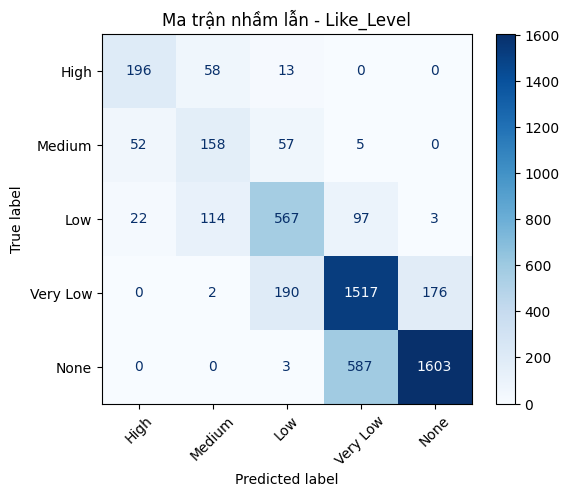

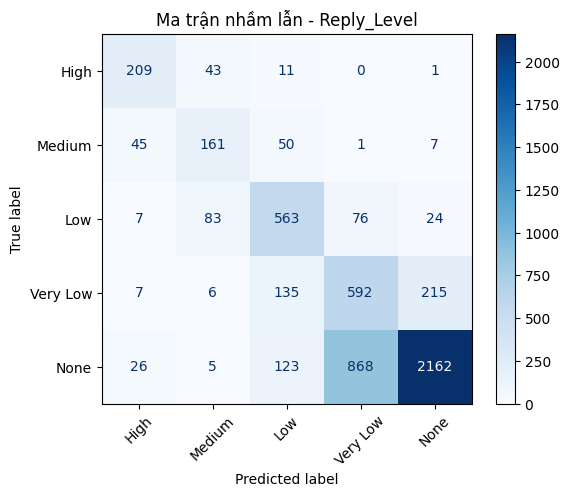

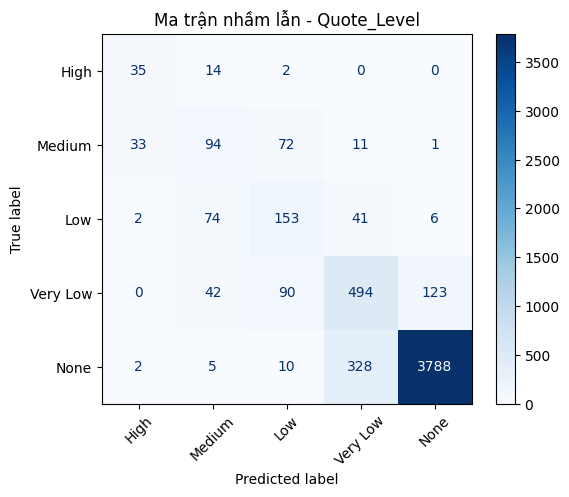

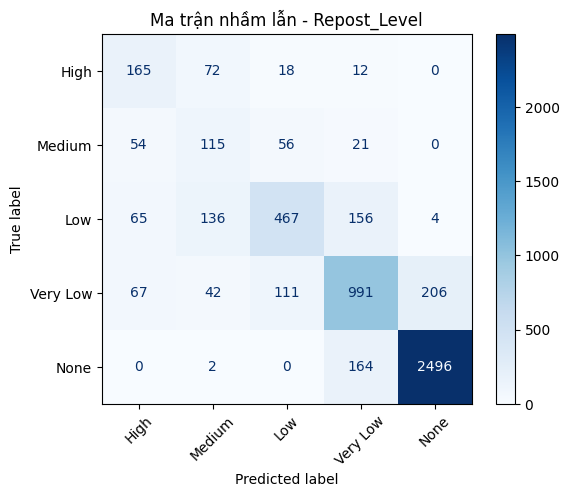

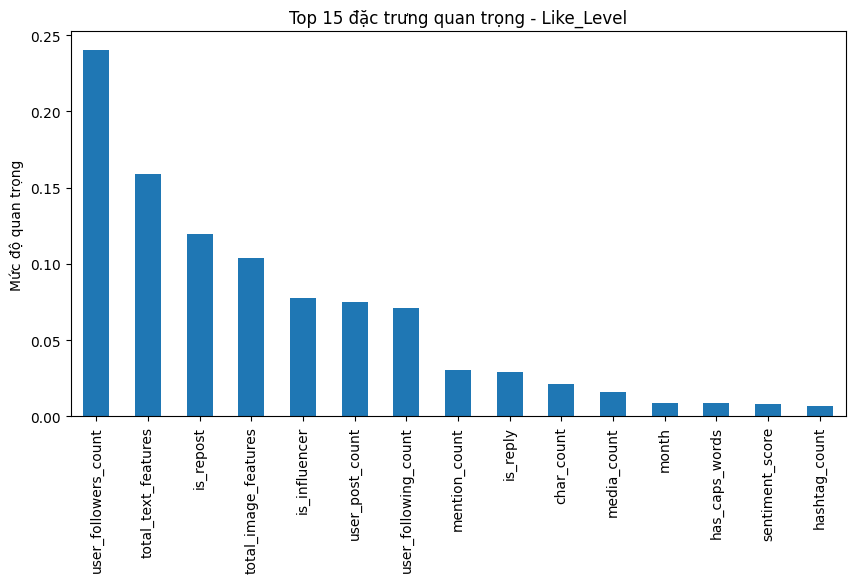

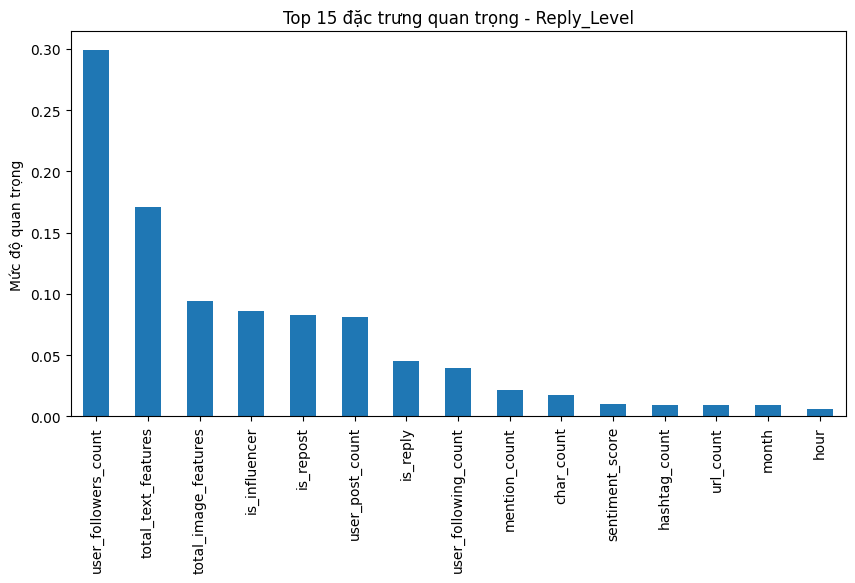

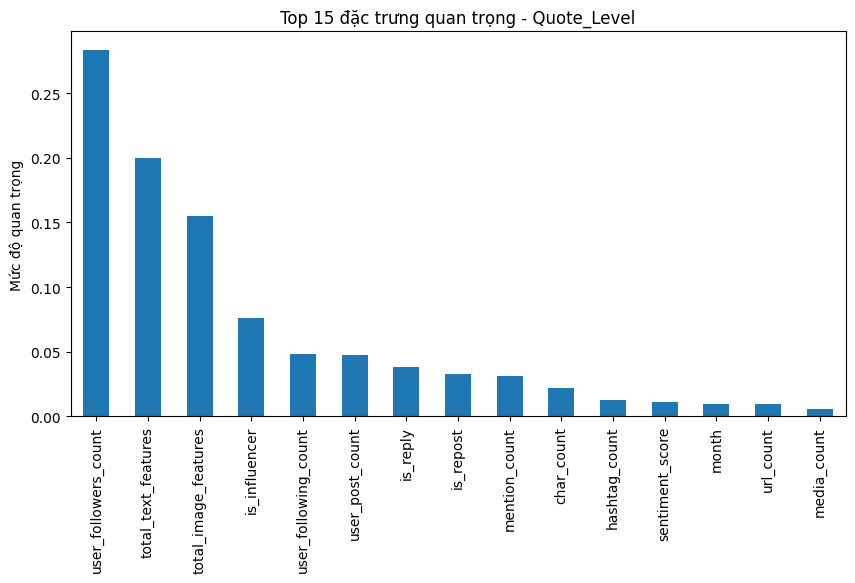

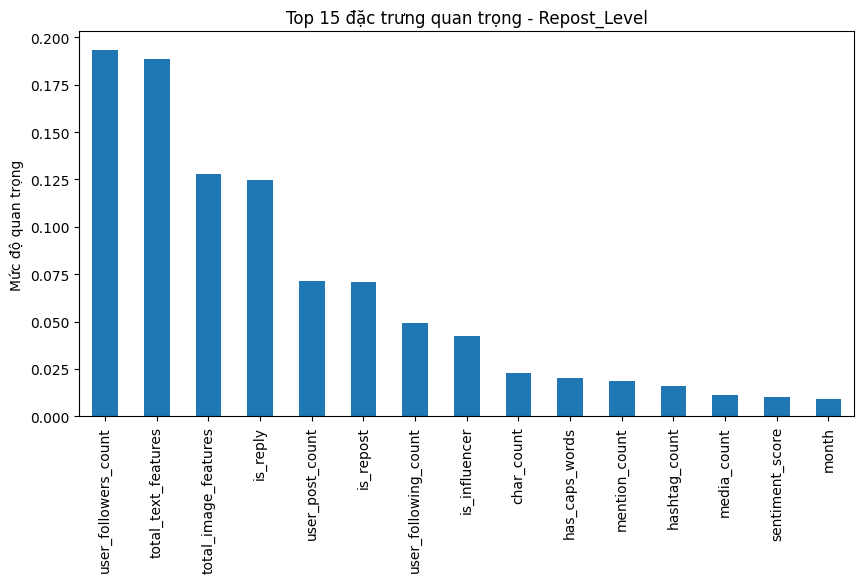

['model/model_full_multimodal.joblib']

In [3]:
# Kết nối dữ liệu
collection = client['db']['posts_full']
df = pd.DataFrame(list(collection.find()))

# Xác định cột đầu ra
target_cols = ['Like_Level', 'Reply_Level', 'Quote_Level', 'Repost_Level']
feature_cols = [col for col in df.columns if col not in target_cols + ['_id']]

# Chuyển đổi nhãn sang số
label_encoders = {}
for col in target_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Chạy GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Trích xuất đặc trưng văn bản
text_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2', device=DEVICE)
text_embeddings = text_model.encode(
    df['cleaned_text'].fillna('').tolist(),
    batch_size=64,
    show_progress_bar=True
)

pca_text = PCA(n_components=20, random_state=20)
text_features = pca_text.fit_transform(text_embeddings)

# Trích xuất đặc trưng media
effnet_model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
effnet_backbone = torch.nn.Sequential(
    effnet_model.features,
    torch.nn.AdaptiveAvgPool2d((1, 1))
)
effnet_backbone.eval().to(DEVICE)
image_transform = EfficientNet_B0_Weights.DEFAULT.transforms()

def extract_image_features(image: Image.Image):
    tensor = image_transform(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        feats = effnet_backbone(tensor)
    return feats.squeeze().cpu().numpy()

def extract_video_features(video_path: str, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total == 0:
        cap.release()
        return None
    idxs = np.linspace(0, total - 1, num_frames, dtype=int)
    feats = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            feats.append(extract_image_features(img))
    cap.release()
    if feats:
        return np.max(np.stack(feats), axis=0)
    return None

def extract_media_features(media_paths):
    feats = []
    if not isinstance(media_paths, list):
        return np.zeros(1280)
    for path in media_paths:
        if not os.path.exists(path):
            continue
        try:
            ext = os.path.splitext(path)[1].lower()
            if ext in ['.jpg', '.jpeg', '.png']:
                img = Image.open(path).convert('RGB')
                feats.append(extract_image_features(img))
            elif ext == '.mp4':
                f = extract_video_features(path)
                feats.append(f if f is not None else np.zeros(1280))
        except Exception:
            continue
    if feats:
        return np.mean(np.stack(feats), axis=0)
    return np.zeros(1280)

# Trích xuất toàn bộ media
image_features_list = []
for media_paths in tqdm(df['media_path_list'], desc='Trích xuất media'):
    feat = extract_media_features(media_paths)
    image_features_list.append(feat)
image_features_array = np.vstack(image_features_list)

pca_image = PCA(n_components=40, random_state=20)
image_features = pca_image.fit_transform(image_features_array)

# Xử lý đặc trưng 
drop_cols = ['_id', 'cleaned_text', 'media_path_list'] + target_cols
base_features = df.drop(columns=drop_cols, errors='ignore')
base_feature_names = base_features.columns

# Tạo dữ liệu đầy đủ
X_full = np.hstack([base_features, 
                    text_features, 
                    image_features])
Y_full = df[target_cols].astype(int).values

# In số lượng đặc trưng
print(f"Số đặc trưng gốc: {base_features.shape[1]}")
print(f"Số đặc trưng text: {text_features.shape[1]}")
print(f"Số đặc trưng image: {image_features.shape[1]}")
print(f"Tổng đặc trưng: {X_full.shape[1]}")

# Chia train/test
X_train, X_test, Y_train, Y_test = train_test_split(
    X_full, Y_full, test_size=0.3, random_state=20
)

# Huấn luyện mô hình đa nhãn
rf = RandomForestClassifier(
    n_estimators=300,
    max_features=0.4,
    min_samples_leaf=12,
    max_depth=12,
    class_weight='balanced',
    n_jobs=-1,
    random_state=20
)
multi_rf = MultiOutputClassifier(rf, n_jobs=-1)
multi_rf.fit(X_train, Y_train)

# Đánh giá
order_labels = ['High', 'Medium', 'Low', 'Very Low', 'None']
label_to_ordered_int = {label: i for i, label in enumerate(order_labels)}

def reorder_labels(arr, le, label_to_ordered_int):
    original_labels = le.inverse_transform(arr)
    reordered = [label_to_ordered_int[label] for label in original_labels]
    return np.array(reordered)

# Đánh giá
Y_pred = multi_rf.predict(X_test)

for i, label in enumerate(target_cols):
    le = label_encoders[label]
    Y_test_reordered = reorder_labels(Y_test[:, i], le, label_to_ordered_int)
    Y_pred_reordered = reorder_labels(Y_pred[:, i], le, label_to_ordered_int)
    
    print(f"\n {label}")
    print(classification_report(
        Y_test_reordered, Y_pred_reordered,
        target_names=order_labels,
        zero_division=0
    ))

# Ma trận nhầm lẫn
for i, label in enumerate(target_cols):
    le = label_encoders[label]
    Y_test_reordered = reorder_labels(Y_test[:, i], le, label_to_ordered_int)
    Y_pred_reordered = reorder_labels(Y_pred[:, i], le, label_to_ordered_int)

    cm = confusion_matrix(Y_test_reordered, Y_pred_reordered)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=order_labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f'Ma trận nhầm lẫn - {label}')
    plt.show()

# Độ quan trọng
feature_cols_all = list(base_feature_names) + \
                   [f'text_pca_{i+1}' for i in range(text_features.shape[1])] + \
                   [f'image_pca_{i+1}' for i in range(image_features.shape[1])]

for i, label in enumerate(target_cols):
    importances = multi_rf.estimators_[i].feature_importances_
    feat_imp = pd.Series(importances, index=feature_cols_all)

    text_mask = feat_imp.index.str.startswith('text_pca_')
    image_mask = feat_imp.index.str.startswith('image_pca_')

    base_feat_imp = feat_imp[~(text_mask | image_mask)]
    text_importance = feat_imp[text_mask].sum()
    image_importance = feat_imp[image_mask].sum()

    feat_plot = base_feat_imp.copy()
    feat_plot["total_text_features"] = text_importance
    feat_plot["total_image_features"] = image_importance
    feat_plot = feat_plot.sort_values(ascending=False).head(15)

    plt.figure(figsize=(10, 5))
    feat_plot.plot(kind='bar')
    plt.title(f'Top 15 đặc trưng quan trọng - {label}')
    plt.ylabel('Mức độ quan trọng')
    plt.show()

# Lưu mô hình
joblib.dump({
    'model': multi_rf,
    'label_encoders': label_encoders,
    'pca_text': pca_text,
    'pca_image': pca_image,
    'features': feature_cols_all
}, 'model/model_full_multimodal.joblib')